Load all necessary imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import h5py

# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-03-12 17:51:11.409412: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 17:51:11.441810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 17:51:11.441848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 17:51:11.442703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 17:51:11.448099: I tensorflow/core/platform/cpu_feature_guar

Data Loading

In [2]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)

In [3]:
boxes.shape

(10000, 280, 5)

Data Normalization

In [4]:
image_normalized = (images+1e-9)/9.26 # Normalize images and add noise


# Normalize bounding boxes
normalized_boxes = boxes / [1,64,64,64,64]

Model Train


In [17]:
from tensorflow.keras import layers, models



input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 4

max = 200

images_np = image_normalized[:max]
# images_np = tf.expand_dims(images_np[:max], axis=-1)
probabilities = np.array(normalized_boxes[:max, :,:-4])
# probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:max, :, 1:])
# boxes_np = tf.expand_dims(boxes_np, axis=1)

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))


In [18]:
print(images_np.shape)
print(probabilities.shape)

print(boxes_np.shape)

(200, 64, 64)
(200, 280, 1)
(200, 280, 4)


In [19]:

dataset = dataset.batch(64)
dataset = dataset.shuffle(buffer_size=400, reshuffle_each_iteration=True) 

x_input = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
 

x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)


x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x


x = layers.Flatten()(x)
# Bounding box output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob_reshape')(x)

x_prob_reshape = tf.expand_dims(x_prob, axis=2)


x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)

model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Consider adjusting based on performance


model.compile(
    optimizer=optimizer,
    loss={
        'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 
        'x_boxes_reshape': tf.keras.losses.MeanSquaredError()
    },
    loss_weights={
        'x_prob_reshape': .3,  # Replace with your desired weight
        'x_boxes_reshape': 1.7  # Replace with your desired weight
    }
)

num_epochs = 3000


In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 64, 64, 64)           640       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_20[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_4 (Bat  (None, 32, 32, 64)           256       ['max_pooling2d_10[0][0]

In [21]:
dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 64, 64), dtype=tf.float64, name=None), {'x_prob_reshape': TensorSpec(shape=(None, 280, 1), dtype=tf.float64, name=None), 'x_boxes_reshape': TensorSpec(shape=(None, 280, 4), dtype=tf.float64, name=None)})>

In [22]:
# Assuming you've already prepared train_dataset and val_dataset as shown previously

# Fit the model
history = model.fit(
    dataset,  # Training data
    epochs=num_epochs
        # Add other callbacks here as needed, such as ModelCheckpoint or ReduceLROnPlateau   
)





Epoch 1/3000


ValueError: in user code:

    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 248, in __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 63, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 819, in map_to_output_names
        raise ValueError(

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['x_prob_reshape']). Valid mode output names: ['tf.expand_dims_2', 'x_boxes_reshape']. Received struct is: {'x_prob_reshape': <tf.Tensor 'IteratorGetNext:2' shape=(None, 280, 1) dtype=float64>}.


In [12]:


#model.save('modelM11copywithnoBN_josh.h5')



/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
loaded_model = tf.keras.models.load_model('modelM11copywithnoBN_josh.h5')


In [15]:
boxes.shape

(10000, 280, 5)

In [10]:
# dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
# # dataset = dataset.batch(400)
# # inputs, targets = next(iter(dataset))
output = model.predict(dataset)

4/4 [==============================] - 0s 14ms/step


In [11]:
targets['x_boxes_reshape'][0]

NameError: name 'targets' is not defined

In [16]:
probab.shape

(200, 280, 4)

In [14]:
output[0].shape

(200, 1, 280, 1)

In [117]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_prob_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[0], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn =  tf.keras.losses.BinaryCrossentropy()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())


MSE Loss: 4.662502931844808e-07


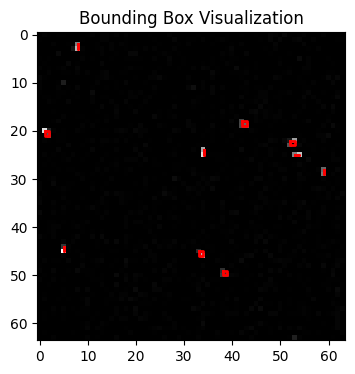

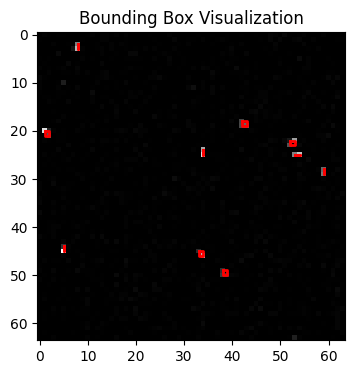

In [129]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,400)


visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction



